In [1]:
%matplotlib inline  
import torch 
from torch import nn
import sys
sys.path.append('../') 
import utils as d2l

1. generate data

In [2]:
T = 1000 # 总共产生1000个点  
time = torch.arange(1, T + 1, dtype=torch.float32)  
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))  
time.shape,x.shape

(torch.Size([1000]), torch.Size([1000]))

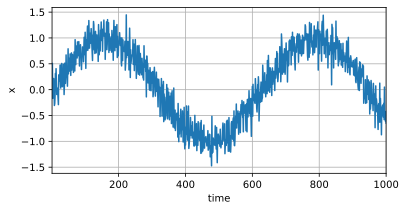

In [3]:
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

2. make features-label

In [4]:
tau = 4  
 #在 Autoregressive models 中舍弃了前面tau个样本,第一个样本是从y_tau+1开始的,所以总样本数为(T-tau)
features = torch.zeros((T - tau, tau)) #对于x_t,我们只利用当前值的前tau个作为features
for i in range(tau):  
    features[:, i] = x[i: T - tau + i] 
print(features.shape)
labels = x[tau:].reshape((-1, 1))# 样本从tau+1开始
batch_size, n_train = 16, 600 # 只有前n_train个样本用于训练  
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),  batch_size, is_train=True)
features[:n_train].shape

torch.Size([996, 4])


torch.Size([600, 4])

In [5]:
# 初始化网络权重的函数  
def init_weights(m):  
    if type(m) == nn.Linear:  
        nn.init.xavier_uniform_(m.weight)  
# 一个简单的多层感知机  
def get_net():  
    net = nn.Sequential(
        nn.Linear(4, 10),  
        nn.ReLU(),  
        nn.Linear(10, 1))  
    net.apply(init_weights)  
    return net  
# 平方损失。注意:MSELoss计算平方误差时不带系数1/2  
loss = nn.MSELoss(reduction='none')

In [6]:
def train(net, train_iter, loss, epochs, lr):  
    trainer = torch.optim.Adam(net.parameters(), lr) 
    for epoch in range(epochs):  
        for X, y in train_iter: 
            trainer.zero_grad() 
            l = loss(net(X), y)  
            l.sum().backward()  
            trainer.step()  
        print(f'epoch {epoch + 1}, '  f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')  
net = get_net() 
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.066263
epoch 2, loss: 0.059345
epoch 3, loss: 0.056792
epoch 4, loss: 0.056753
epoch 5, loss: 0.056789


3. 对单步预测进行检验

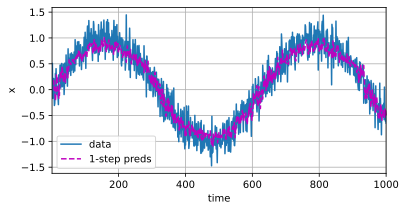

In [7]:
onestep_preds = net(features)  
d2l.plot([time, time[tau:]],  
         [x.detach().numpy(), onestep_preds.detach().numpy()],#预测是是从tau+1开始
         'time',  'x', legend=['data', '1-step preds'], xlim=[1, 1000],  figsize=(6, 3))

在单步观测中，我们使用的是自己观测的数据来对下一个time step进行预测，误差没有累计，因此预测的效果比较不错

4. 多步观测

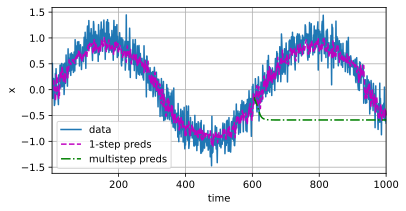

In [8]:
multistep_preds = torch.zeros(T)  
multistep_preds[: n_train + tau] = x[: n_train + tau]  # 前面n_train+tau是观测数据
for i in range(n_train + tau, T):  
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))
d2l.plot([time, time[tau:], time[n_train + tau:]],  
         [x.detach().numpy(), onestep_preds.detach().numpy(),  
          multistep_preds[n_train + tau:].detach().numpy()], 
         'time',  'x', legend=['data', '1-step preds', 'multistep preds'],  
         xlim=[1, 1000], figsize=(6, 3))

在多步观测中，由于后面的预测都是基于前面预测出来的结果进行下一步预测，会产生误差累加，最后误差的影响使得未来的预测趋近于一个常数

5. 基于k = 1, 4, 16, 64,通过对整个序列预测的计算,让我们更仔细地看一下k步预测的困难。

In [9]:
max_steps = 64

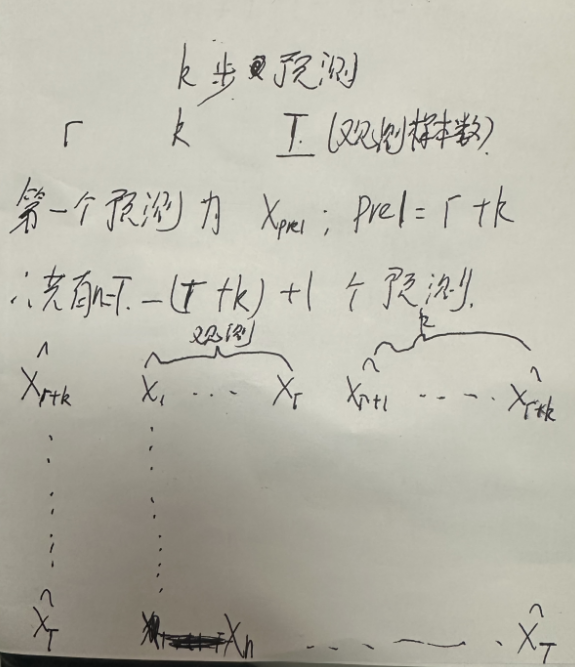

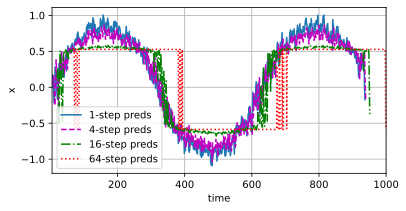

In [10]:
n=T - tau - max_steps + 1 #第一预测的是x_{tau+max_steps}, 预测的总数共num_pre
features = torch.zeros((n, tau + max_steps))   
# 观测数据
for i in range(tau):  
    features[:, i] = x[i: n+i] 
#pred time step: tau+1->tau+k
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)
steps = (1, 4, 16, 64)  
d2l.plot(
    [time[tau - 1 + k: tau - 1 + k+n] for k in steps],  #time_step: tau +k:tau+k+n->(tau-1)+k:(tau-1)+k+n
    [features[:, (tau  - 1+ i)].detach().numpy() for i in steps], 
    'time', 'x',  legend=[f'{i}-step preds' for i in steps], 
    xlim=[5, 1000],  figsize=(6, 3))